In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
class DistributionUncertainty(nn.Module):
    """
    Distribution Uncertainty Module
        Args:
        p   (float): probabilty of foward distribution uncertainty module, p in [0,1].

    """

    def __init__(self, p=0.5, eps=1e-6):
        super(DistributionUncertainty, self).__init__()
        self.eps = eps
        self.p = p
        self.factor = 1.0

    # 重参数化
    def _reparameterize(self, mu, std):
        epsilon = torch.randn_like(std) * self.factor
        return mu + epsilon * std

    def sqrtvar(self, x):
        t = (x.var(dim=0, keepdim=True) + self.eps).sqrt()  # 注意这里是求平方根
        t = t.repeat(x.shape[0], 1)  # ？？？？
        return t

    def forward(self, x):
        # if (not self.training) or (np.random.random()) > self.p:
        #     return x

        mean = x.mean(dim=[2, 3], keepdim=False)
        std = (x.var(dim=[2, 3], keepdim=False) + self.eps).sqrt()

        sqrtvar_mu = self.sqrtvar(mean)
        sqrtvar_std = self.sqrtvar(std)

        beta = self._reparameterize(mean, sqrtvar_mu)
        gamma = self._reparameterize(std, sqrtvar_std)

        x = (x - mean.reshape(x.shape[0], x.shape[1], 1, 1)) / std.reshape(x.shape[0], x.shape[1], 1, 1)
        x = x * gamma.reshape(x.shape[0], x.shape[1], 1, 1) + beta.reshape(x.shape[0], x.shape[1], 1, 1)

        return x


In [4]:
data_batch = torch.randn((32, 3, 64, 64))
data_batch = torch.cat((torch.from_numpy(np.random.normal(1,3, data_batch.shape)) , data_batch), dim=0) 
# data_batch = data_batch.mean((2,3))
uncertainty = DistributionUncertainty()
perturb_data = uncertainty(data_batch)
data_batch = data_batch.view((data_batch.shape[0], -1))
perturb_data = perturb_data.view(perturb_data.shape[0], -1)

print(perturb_data.mean(), " ", data_batch.mean())

X_origin = (TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(data_batch.numpy())).T
X_perturb = (TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(perturb_data.numpy())).T

tensor(0.5875, dtype=torch.float64)   tensor(0.4964, dtype=torch.float64)


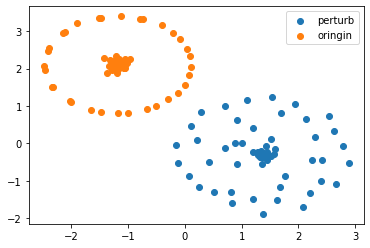

In [5]:
plt.scatter(X_perturb[0], X_perturb[1], label="perturb")
plt.scatter(X_origin[0], X_origin[1], label="oringin")
plt.legend()
num = 1
plt.savefig(f"./{num}.png")

In [79]:
from utils.PACS import PACS
dataloader = PACS("E:/Anaconda/Library/home/lw/lw/data/", "pacs")

Getting pacs datasets


PermissionError: [Errno 13] Permission denied: 'E:/Anaconda/Library/home/lw/lw/data//pacs/art_painting/dog'

探究进行扰动前后的特征统计量的分布关系